In [1]:
import os
import pickle
import matplotlib.pylab as plt
import utils

In [9]:
# STORE = False
STORE = False

## Load from raw data (on server only)

In [3]:
with open("/export/share/krausef99dm/data/ptr_data/ptr_data.pkl", 'rb') as f:
    ordered_dict = pickle.load(f)

In [28]:
# in nucleotides!
seq_lens_all = []
seq_lens_all_cds = []

for identifier, content in ordered_dict.items():
    sequence = content['fasta']
    bed_annotation = content['bed_annotation']
    
    coding_sequence = [nucleotide for nucleotide, annotation in zip(list(sequence), bed_annotation) if
                       annotation not in [5, 3]]  # CDS, drop 5' and 3' UTR

    seq_lens_all.append(len(sequence))
    seq_lens_all_cds.append(len(coding_sequence))

In [5]:
path_seq_train = "/export/share/krausef99dm/data/data_train/train_9.0k_data.pkl"
path_seq_val = "/export/share/krausef99dm/data/data_test/val_9.0k_data.pkl"
path_seq_test = "/export/share/krausef99dm/data/data_test/test_9.0k_data.pkl"

# FAULTY - should be 8.1k!
#path_cod_train = "/export/share/krausef99dm/data/data_train/codon_train_2.7k_data.pkl"
#path_cod_val = "/export/share/krausef99dm/data/data_test/codon_val_2.7k_data.pkl"
#path_cod_test = "/export/share/krausef99dm/data/data_test/codon_test_2.7k_data.pkl"

# CORRECTED
path_cod_train = "/export/share/krausef99dm/data/data_train/codon_train_8.1k_data.pkl"
path_cod_val = "/export/share/krausef99dm/data/data_test/codon_val_8.1k_data.pkl"
path_cod_test = "/export/share/krausef99dm/data/data_test/codon_test_8.1k_data.pkl"

In [6]:
with open(path_seq_train, 'rb') as f:
    rna_data, _, _, _ =  pickle.load(f)

In [7]:
rna_data[0].shape

torch.Size([3382, 4])

In [8]:
def get_seq_lens(path):
    rna_data = None
    with open(path, 'rb') as f:
        rna_data, _, _, _ =  pickle.load(f)
    return [len(array) for array in rna_data]

In [10]:
# in nucleotides!
seq_train = get_seq_lens(path_seq_train)
seq_val = get_seq_lens(path_seq_val)
seq_test = get_seq_lens(path_seq_test)

# in codons!
cod_train = get_seq_lens(path_cod_train)
cod_val = get_seq_lens(path_cod_val)
cod_test = get_seq_lens(path_cod_test)

cod_train, cod_val, cod_test = [[i * 3 for i in ls] for ls in [cod_train, cod_val, cod_test]]

In [37]:
# pickle to data in vis
data_list = [seq_lens_all, seq_lens_all_cds, seq_train, seq_val, seq_test, cod_train, cod_val, cod_test]

# Save to a pickle file on server
with open("data/seq_len_data.pkl", "wb") as f:
    pickle.dump(data_list, f)

## Load from checkpoint

In [72]:
# Load from the pickle file
with open("data/seq_len_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Unpack the data
seq_lens_all, seq_lens_all_cds, seq_train, seq_val, seq_test, cod_train, cod_val, cod_test = loaded_data

## Analysis

In [14]:
initial_len = len(seq_lens_all)
print(initial_len)
# seq longer than 20k

11279


In [15]:
# Max seq length
max(seq_lens_all)

109224

In [17]:
# Max seq length (only CDS)
max(seq_lens_all_cds)

107976

In [18]:
# remove above specific threshold
seq_lens_all = [l for l in seq_lens_all if l < 15_000]

print("new len", len(seq_lens_all))
print("Lost sequence-tissue tuples:", initial_len - len(seq_lens_all))

new len 11208
Lost sequence-tissue tuples: 71


In [29]:
# FOR THESIS: How many samples of codon dataset where lost in hyperparameter tuning due to factor 3 issue?
sum([1 for l in seq_lens_all_cds if (l <= 8100) and (l > 2700)])

1928

In [19]:
# remove above specific threshold
seq_lens_all_cds = [l for l in seq_lens_all_cds if l < 15_000]

print("new len", len(seq_lens_all_cds))
print("Lost sequence-tissue tuples:", initial_len - len(seq_lens_all_cds))

new len 11264
Lost sequence-tissue tuples: 15


(array([6503., 3203.,  945.,  321.,  131.,   77.,   31.,   18.,   18.,
          17.]),
 array([  114. ,  1597.8,  3081.6,  4565.4,  6049.2,  7533. ,  9016.8,
        10500.6, 11984.4, 13468.2, 14952. ]),
 <BarContainer object of 10 artists>)

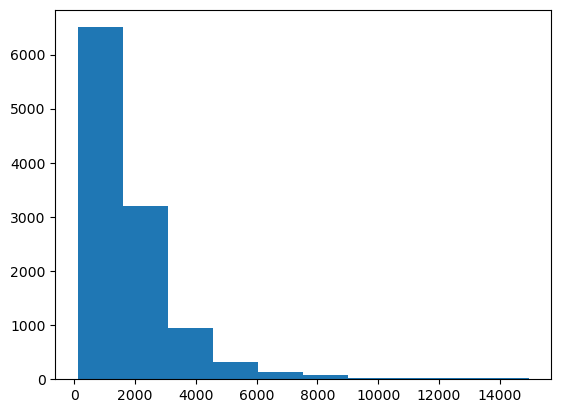

In [20]:
plt.hist(seq_lens_all_cds)

In [36]:
sum([1 for l in seq_lens_all_cds if l <= 8100])

11141

(array([ 467.,  893., 1220., 1400., 1200., 1003.,  872.,  718.,  644.,
         496.,  431.,  348.,  267.,  213.,  172.,  166.,  134.,   96.,
          86.,   75.,   55.,   62.,   38.,   29.,   24.,   31.,   24.,
          14.,   18.,   12.]),
 array([  303.        ,   792.36666667,  1281.73333333,  1771.1       ,
         2260.46666667,  2749.83333333,  3239.2       ,  3728.56666667,
         4217.93333333,  4707.3       ,  5196.66666667,  5686.03333333,
         6175.4       ,  6664.76666667,  7154.13333333,  7643.5       ,
         8132.86666667,  8622.23333333,  9111.6       ,  9600.96666667,
        10090.33333333, 10579.7       , 11069.06666667, 11558.43333333,
        12047.8       , 12537.16666667, 13026.53333333, 13515.9       ,
        14005.26666667, 14494.63333333, 14984.        ]),
 <BarContainer object of 30 artists>)

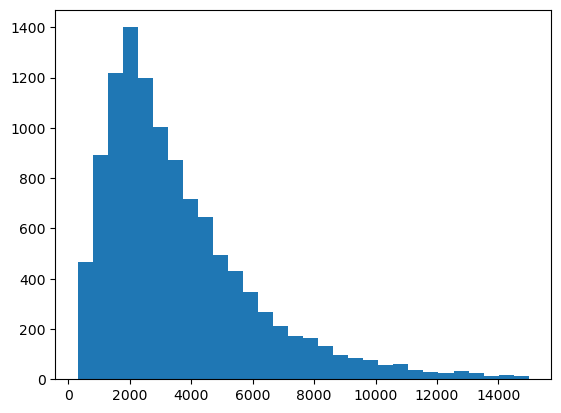

In [25]:
plt.hist(seq_lens_all, bins=30)

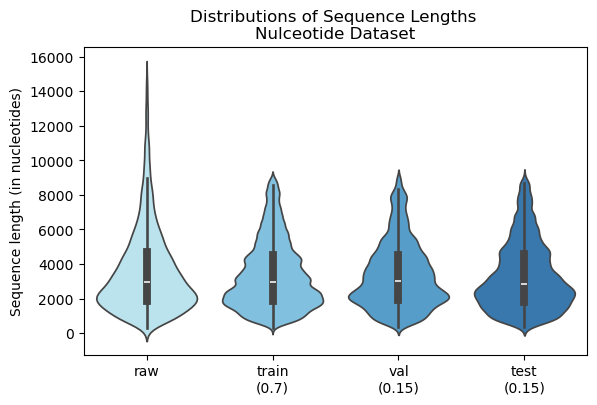

In [26]:
import seaborn as sns
from custom_colors import blue_shades
blue_shades = blue_shades[:4]

# NUCLEOTIDE DATA
data = [seq_lens_all, seq_train, seq_val, seq_test]
labels = ['raw', 'train\n(0.7)', 'val\n(0.15)', "test\n(0.15)"]
plt.figure(figsize=(6.5, 4))
sns.violinplot(data=data, palette=blue_shades)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.title("Distributions of Sequence Lengths \nNulceotide Dataset")
plt.ylabel("Sequence length (in nucleotides)")

if STORE:
    print("Storing")
    plt.savefig(os.getenv("OUTPUT_DIR") + "/sequence_len_distribution_nucl.pdf", format="pdf", bbox_inches="tight")

plt.show()

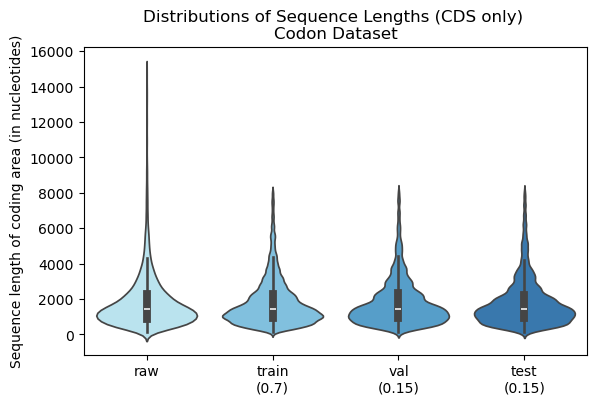

In [27]:
# CODON DATA

data = [seq_lens_all_cds, cod_train, cod_val, cod_test]
labels = ['raw', 'train\n(0.7)', 'val\n(0.15)', "test\n(0.15)"]
plt.figure(figsize=(6.5, 4))
sns.violinplot(data=data, palette=blue_shades)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.title("Distributions of Sequence Lengths (CDS only) \nCodon Dataset")
plt.ylabel("Sequence length of coding area (in nucleotides)")

if STORE:
    print("Storing")
    plt.savefig(os.getenv("OUTPUT_DIR") + "/sequence_len_distribution_codon.pdf", format="pdf", bbox_inches="tight")

plt.show()